In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
#from b3d.utils import unproject_depth
import rerun as rr
import genjax
from tqdm import tqdm


rr.init("demo.py")
rr.connect("127.0.0.1:8812")

In [2]:
width=128
height=128
fx=64.0
fy=64.0
cx=64.0
cy=64.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

In [3]:
from b3d.pose import from_axis_angle

In [4]:
r_mat = from_axis_angle(jnp.array([0,0,1]), jnp.pi/2)

In [5]:
vec_transform_axis_angle = jax.vmap(from_axis_angle, (None, 0))
rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(0, 4*jnp.pi/8, 30)) 
#rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(0, 7*jnp.pi/8, 30)) 

In [6]:
object_library = b3d.MeshLibrary.make_empty_library()
occluder = trimesh.creation.box(extents=jnp.array([0.001, 0.1, 0.1]))
occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)


cam_inv_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.15, 0.15, 0.0]),
    jnp.array([0.0, 0.0, 0.0])
).inv()


in_place_rots = rots


compound_pose = cam_inv_pose @ in_place_rots #in_place_rot


rgbs, depths = renderer.render_attribute_many(
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)

In [7]:
from b3d.utils import unproject_depth
unproject_depth_vec = jax.vmap(unproject_depth, (0, None))
xyzs = unproject_depth_vec(depths, renderer)

In [8]:
from b3d import Pose

num_layers = 2048
renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, num_layers)
model = b3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)
update_jit = jax.jit(model.update)

# Arguments of the generative model.
# These control the inlier / outlier decision boundary for color error and depth error.
#color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.02))
color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.01))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(50.0), jnp.float32(0.001)) # 5
# TODO: explain
color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))


# Defines the enumeration schedule.
key = jax.random.PRNGKey(0)
# Gridding on translation only.

delta = 0.0015 #0.005
grid_dim = 23
translation_deltas = Pose.concatenate_poses([jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-delta, delta, grid_dim),
        jnp.linspace(-delta, delta, grid_dim),
        jnp.linspace(-delta, delta, grid_dim),
    ),
    axis=-1,
).reshape(-1, 3)), Pose.identity()[None,...]])
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = Pose.concatenate_poses([jax.vmap(Pose.sample_gaussian_vmf_pose, in_axes=(0,None, None, None))(
    jax.random.split(jax.random.PRNGKey(0), grid_dim*grid_dim*grid_dim),
    Pose.identity(),
    0.00001, 10.0
), Pose.identity()[None,...]])
all_deltas =  Pose.stack_poses([translation_deltas, rotation_deltas])
all_deltas = (all_deltas[0] @ all_deltas[1])[None,...]

In [9]:
# Make empty library
object_library = b3d.MeshLibrary.make_empty_library()

x_center = 64
y_center = 64 
del_pix = 5 

local_points = xyzs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
local_rgbs = rgbs[0,x_center-del_pix:x_center+del_pix,y_center-del_pix:y_center+del_pix,:].reshape(-1,3)
patch_center = xyzs[0,x_center,y_center,:]

point_cloud = local_points
point_cloud_colors = local_rgbs

In [10]:
def _enumerate_and_return_scores(trace, addressses, key, all_deltas):
    addr = addressses.const[0]
    current_pose = trace[addr]
    for i in range(len(all_deltas)):
        test_poses = current_pose @ all_deltas[i]
        potential_scores = b3d.enumerate_choices_get_scores(
            trace, jax.random.PRNGKey(0), addressses, test_poses
        )
        #current_pose = test_poses[potential_scores.argmax()]
    #trace = b3d.update_choices(trace, key, addressses, current_pose)
    return test_poses, potential_scores


enumerate_and_return_scores = jax.jit(
    _enumerate_and_return_scores, static_argnames=["addressses"]
)

In [11]:
# Create new mesh.
vertices, faces, vertex_colors, face_colors = b3d.make_mesh_from_point_cloud_and_resolution(
    point_cloud, point_cloud_colors, point_cloud[:,2] / fx * 2.0
)
object_pose = Pose.from_translation(vertices.mean(0))
vertices = object_pose.inverse().apply(vertices)
object_library.add_object(vertices, faces, vertex_colors)


In [12]:

model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", object_pose),
            ("object_0", 0),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(1),model_args, object_library)
)

# Visualize trace
#b3d.rerun_visualize_trace_t(trace, 0)

FINAL_T = len(xyzs)
scores = []
score_entrs = []
for T_observed_image in tqdm(range(0, FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[T_observed_image],xyzs[T_observed_image,...,2])
    )
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const(["camera_pose"]), key, all_deltas)
    # trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)

    poses, grid_scores = enumerate_and_return_scores(trace, genjax.Pytree.const(["object_pose_0"]), key, all_deltas)
    indices = jnp.argsort(-grid_scores)
    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()

    image_sum = np.zeros(rendered_rgb.shape)

    # this is wrong, just a visualization of the fineness of the grid

    # this looks at the highest-scoring 50 samples!, but uniformly weights them

    
    # for ind in indices[:50:5]:
    #     temp_trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), poses[ind])
    #     (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = temp_trace.get_retval()
    #     scores.append(temp_trace.get_score())
    #     image_sum += np.array(rendered_rgb)
    
    score_probs = jnp.exp(grid_scores - jax.scipy.special.logsumexp(grid_scores))

    num_samples = 50

    #print(score_probs[jnp.argsort(-score_probs)[:num_samples]])
    sampled_indices = jax.random.choice(key, jnp.arange(len(score_probs)), shape = (num_samples,), p=score_probs)
    score_entr = jnp.sum(jax.scipy.special.entr(score_probs))

    for ind in sampled_indices:
        temp_trace = b3d.update_choices_jit(trace, key, genjax.Pytree.const([f"object_pose_0"]), poses[ind])
        (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = temp_trace.get_retval()
        image_sum += np.array(rendered_rgb)

    
    image_sum /= num_samples
    
    trace,key = b3d.enumerate_and_select_best_move(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)
    #trace,key = b3d.enumerate_and_sample(trace, genjax.Pytree.const([f"object_pose_0"]), key, all_deltas)
    # enumerate and sample does worse?

    (observed_rgb, rendered_rgb), (observed_depth, rendered_depth) = trace.get_retval()

    score = trace.get_score()
    scores.append(score)
    score_entrs.append(score_entr)
    #b3d.rerun_visualize_trace_t(trace, T_observed_image)

    rr.set_time_sequence("frame", T_observed_image)
    rr.log("/vmf_tracking", rr.Image(observed_rgb))
    rr.log("/vmf_tracking/rgb_rendering", rr.Image(rendered_rgb))
    rr.log("/observed_im", rr.Image(observed_rgb))
    rr.log("/alpha_blend_patch", rr.Image(image_sum))
    rr.log('/vmf_score_loglik', rr.TimeSeriesScalar(score))

    (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask) = b3d.get_rgb_depth_inliers_from_trace(trace)
    rr.log("/color_inliers", rr.DepthImage(color_inliers * 1.0))

  0%|          | 0/30 [00:00<?, ?it/s]/var/tmp/ipykernel_34859/552221741.py:82: DeprecationWarning: Use the `Scalar` + (optional) `SeriesLine`/`SeriesPoint` archetypes instead, logged on the same entity. See [0.13 migration guide](https://www.rerun.io/docs/reference/migration/migration-0-13).
  rr.log('/vmf_score_loglik', rr.TimeSeriesScalar(score))
100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


Text(0.5, 1.0, 'unoccluded path (discrete entropy on truncated posterior grid)')

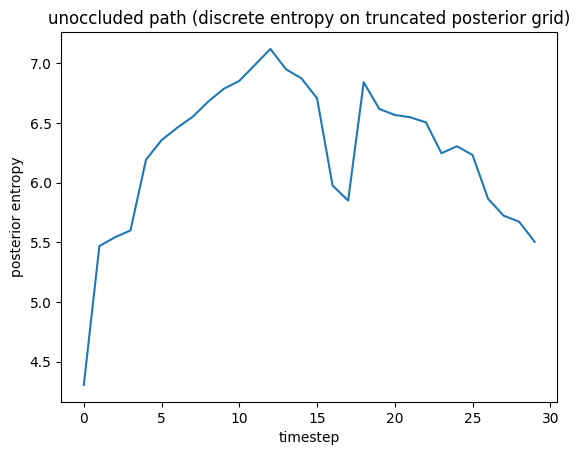

In [13]:
# make a version where the patch disappears and reappears (uniform entropy)
# make a version with this scaled to real data
# make version with actual posterior samples vs argmaxing

plt.plot(score_entrs)
plt.xlabel('timestep')
plt.ylabel('posterior entropy')
plt.title('unoccluded path (discrete entropy on truncated posterior grid)')

In [14]:
# marginalize out scores along an axis
# plot 2d projection of bayesian grid approximation? need x and y grid sample location data

In [15]:
all_deltas.shape

(1, 12168)

In [16]:
enumerator = jax.jit(
    b3d.enumerate_choices_get_scores, static_argnames=["addressses"]
)

grid_scores = enumerator(trace, jax.random.PRNGKey(0), genjax.Pytree.const(["object_pose_0"]), trace["object_pose_0"] @ all_deltas[0])

/opt/conda/envs/b3d/lib/python3.11/site-packages/jax/_src/api_util.py:233: SyntaxWarning: Jitted function has invalid argnames {'addressses'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


Text(0.5, 1.0, 'X-Y dimension posterior marginal logprobs')

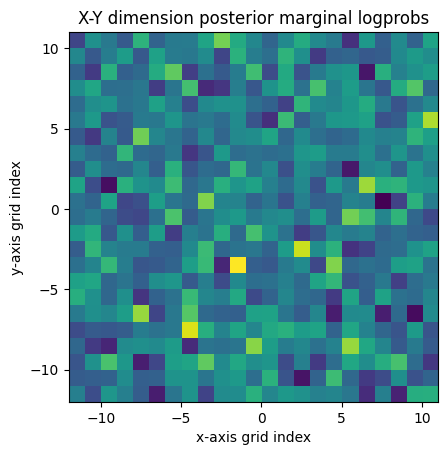

In [17]:
# want x-y axis marginal
marginal = grid_scores[:-1].reshape(jnp.meshgrid(
        jnp.linspace(-delta, delta, grid_dim),
        jnp.linspace(-delta, delta, grid_dim),
        jnp.linspace(-delta, delta, grid_dim),
    )[0].shape).sum(axis=2)

# plot of logprobs
marginal = marginal - jax.scipy.special.logsumexp(marginal)

plt.imshow(marginal, extent=(-grid_dim//2, grid_dim//2, -grid_dim//2, grid_dim//2))
plt.xlabel('x-axis grid index')
plt.ylabel('y-axis grid index')
plt.title('X-Y dimension posterior marginal logprobs')

In [18]:
# TODO: extend results on natural video!

# patch track on natural video
# intrinsic image estimation (which can only be done on natural video)
# lambertian lighting model

In [19]:
# combined statistical power of tests
# approximate scene renderer
# estimation of appearance features
# visibility indicator variable to hierarchically estimate intrinsic image from features

# intrinsic image estimation given geometry and lambertian illumination model

# gradient moves only estimate one position in space, but evaluating the neighborhood gives you access to the local posterior

# frame this in terms of generic viewpoint assumption

# joint estimation problem of assumed light direction

# cosine correction is baked into lambertian appearance model

# ambient light factors from phuong shading

In [ ]:
# clean up current plots